In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [72]:
#LOADING DATA AND PRE PROCESSING
data = pd.read_csv('ASIANPAINT.NS.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.dropna(inplace = True)
#for x in data.Close:
#   if x<2000 or x>4000:
#      print(x)

In [73]:
#FEATURE ENGINEERING
def movingAverage(df , wind):
    return df['Close'].rolling(window=wind).mean()

def RSI(df):
    "returns a pandas series which represents the RSI"
    window = 14
    # Calculate daily price changes
    delta = df['Close'].diff()
    # Separate gains and losses
    gain = delta.where(delta > 0, 0)#where delta>0:gain = 0 where delta <=0
    loss = -delta.where(delta < 0, 0)
    # Calculate the average gain and average loss
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    # Calculate Relative Strength (RS)
    RS = avg_gain / avg_loss
    # Calculate RSI
    RSI = 100 - (100 / (1 + RS))
    return RSI

def detect_bullish_marubozu(df, margin=0.01):
    # Ensure the required columns are present
    required_columns = ['Open', 'Close', 'High', 'Low']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"DataFrame must contain '{col}' column")
    
    # Calculate the allowable margin based on the close price
    allowable_margin = df['Close'] * margin
    
    # Detect bullish Marubozu
    df['Bullish_Marubozu'] = (
        (df['Close'] > df['Open']) &  # Bullish candle
        (df['Open'] <= df['Low'] + allowable_margin) &  # Open near low
        (df['Close'] >= df['High'] - allowable_margin)  # Close near high
    )
    
    return 

def stochastic_oscillator(data):
    data['L14'] = data['Low'].rolling(window=14).min()
    data['H14'] = data['High'].rolling(window=14).max()
    data['stochastic'] = (data['Close'] - data['L14'])*100/(data['H14']-data['L14'])
    data['stochastic_pct'] = data['stochastic'].pct_change()

def ratio(data):
    #ratio of length of body and (high - low)
    data['ratio'] = (data[['Close', 'Open']].max(axis=1) - data[['Open', 'Close']].min(axis=1)) / (data['High'] - data['Low'])
    return 

def up_diff(data):
    data['up_diff'] = (data['High'] - data[['Close','Open']].max(axis=1))/data[['Close','Open']].max(axis=1)
    return

def down_diff(data):
    data['down_diff'] =(data[['Close','Open']].min(axis = 1) - data['Low'])/data[['Close','Open']].min(axis = 1)
    return

def increase(data):
    data['Next_Close'] = data['Close'].shift(-1)
    data['Price_Increase_Next_Day'] = data['Next_Close'] > data['Close']
    
def prev_day(data):
    data['prev_day'] = data['Close'].shift(1)
    data['prev_day_res'] = (data['prev_day'] - data['Close'])/data['prev_day']

def price_increase(data):
    data['price_increase'] = (data['Close']-data['Open'])/data['Open']

def vol_increase(data):
    data['vol_increase'] = (data['Volume']-data['Volume'].rolling(window = 50).mean())/data['Volume'].rolling(50).mean()


data['SMA_10'] = movingAverage(data , 10)
data['SMA_50'] = movingAverage(data , 50)
stochastic_oscillator(data)
data['MACD'] = (movingAverage(data,5) - movingAverage(data,13))/movingAverage(data,13)
data['MACD_ma_comp'] = ( data['MACD']-data['MACD'].rolling(window=4).mean() )/data['MACD'].rolling(window=9).mean()
data['RSI'] = RSI(data)
data['comp_avg'] = (data['Close'] - movingAverage(data,10))/movingAverage(data,30)
detect_bullish_marubozu(data,0.005)
ratio(data)#ratio of length of close and open vs high and low
up_diff(data)#difference bwetween the day high and max of close and open
down_diff(data)
prev_day(data)
increase(data)
price_increase(data)
vol_increase(data)
data = data.dropna()
print(data.to_string())

print(data.shape)

                   Open         High          Low        Close    Adj Close    Volume       SMA_10       SMA_50          L14          H14  stochastic  stochastic_pct      MACD  MACD_ma_comp        RSI  comp_avg  Bullish_Marubozu     ratio   up_diff  down_diff     prev_day  prev_day_res   Next_Close  Price_Increase_Next_Day  price_increase  vol_increase
Date                                                                                                                                                                                                                                                                                                                                                              
2018-09-19  1304.199951  1319.199951  1287.000000  1291.349976  1231.612793    929673  1305.975000  1381.500999  1280.000000  1398.699951    9.561905        0.056948 -0.009407     -0.286002  26.770765 -0.010712             False  0.399068  0.011501   0.003369  1292.099976      0.000580  13

In [17]:

from sklearn.model_selection import train_test_split

X = data[[ 'MACD','MACD_ma_comp','stochastic', 'stochastic_pct', 'RSI' , 'up_diff' , 'down_diff','prev_day_res','comp_avg','vol_increase']]
#VOLUME NEEDS TO BE NORMALIZED
Y = data[['Price_Increase_Next_Day']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
X_val,X_test,y_val,y_test = train_test_split(X_test , y_test, test_size = 0.33,shuffle = False)
#SPLITTING TEST DATA INTO VALIDATION DATA AND TEST DATA BECAUSE VALIDATION WOULD NOT BE CARRIED OUT ALONG WITH THE EPOCHS SIMULTANEOUSLY BUT RATHER SEPARATELY AND MANUALLY
#CHECK LATER WHETHER YOU SHOULD KEEP THE SHUFFLE TO TRUE OR FALSE


In [18]:
from sklearn.preprocessing import StandardScaler
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [29]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss

def predict_with_confidence(model, X, threshold=0.8):
    X = np.asarray(X).astype('float32')
    probabilities = model.predict(X)
    predictions = []
    for prob in probabilities:
        if prob >= threshold:
            predictions.append(1)
        elif prob <= (1 - threshold):
            predictions.append(0)
        else:
            predictions.append(np.nan)  # No prediction (refrain)
    return np.array(predictions), probabilities



In [48]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Model implementation
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32 , activation = 'relu'))
model.add(Dense(32 , activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
custom_optimizer = optimizers.Adam(learning_rate = 0.0001)
model.compile(custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


#function to make predictions by the model only when probability is greater than a certain threshold



#lists to store accuracy over desired number of epochs to obtain separate validation result over each epoch
accuracy_history = []
loss_history = []
num_predictions = []
val_loss_conf_history = []
val_accuracy_conf_history = []
# Train the model
# Custom training loop to include validation predictions
epochs = 30
batch_size = 32
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Train the model for one epoch
    history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size)#no validation testing here ...will be done manually alongside
    # Store the training and validation accuracy and loss
    accuracy_history.append(history.history['accuracy'][0])
    loss_history.append(history.history['loss'][0])

    #Predict on the validation set with confidence threshold
    #X_val = tf.convert_to_tensor(X_val)
    predictions, probabilities = predict_with_confidence(model, X_val)
    valid_indices = ~np.isnan(predictions)#checks and returns value as false only on the elements on which the prediction is NAN
    filtered_predictions = predictions[valid_indices]
    filtered_probabilities = probabilities[valid_indices]
    filtered_y_val = y_val[valid_indices]
    
    # Store the number of confident predictions
    num_predictions.append(len(filtered_predictions))
    
    #Calculate and store validation accuracy and loss for confident predictions
    if len(filtered_predictions) > 0:
        val_accuracy_conf = accuracy_score(filtered_y_val, filtered_predictions)
        val_loss_conf = log_loss(filtered_y_val, filtered_probabilities)
        val_accuracy_conf_history.append(val_accuracy_conf)
        val_loss_conf_history.append(val_loss_conf)
        print(f"Validation accuracy with confident predictions: {val_accuracy_conf:.2f}")
        print(f"Validation loss with confident predictions: {val_loss_conf:.2f}")
        print(f"total possible : {len(predictions)}")
        print(f"number of filtered predictions : {len(filtered_predictions)}")
    else:
        val_accuracy_conf_history.append(np.nan)
        val_loss_conf_history.append(np.nan)
        print("No confident prediction")
        
#For the current model 20-30 seems like the correct number of epochs for the most optimized model


/Users/tejasbaid/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - accuracy: 0.4802 - loss: 0.7051 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation accuracy with confident predictions: 0.53
Validation loss with confident predictions: 3.59
total possible : 287
number of filtered predictions : 265
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.4883 - loss: 0.7015
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
Validation accuracy with confident predictions: 0.53
Validation loss with confident predictions: 3.54
total possible : 287
number of filtered predictions : 263
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.4728 - loss: 0.7017
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
Validation accuracy with confident predictions: 0.53
Validation loss with confident predictions: 3.38
total possible : 287
number of filtered predictions : 260
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.4786 - loss: 0.7050
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
Validation accuracy 

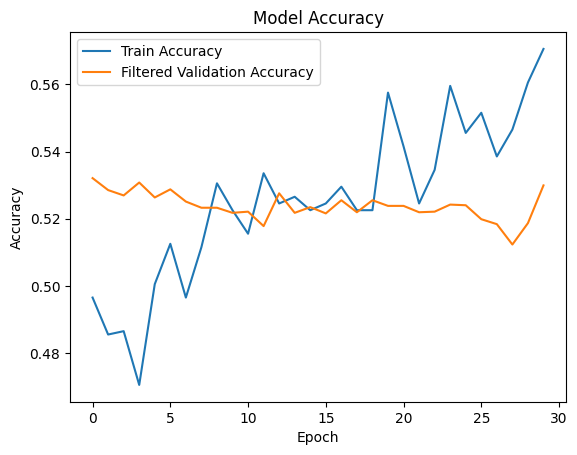

In [49]:
# Plotting training & validation accuracy values
plt.plot(accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_conf_history, label='Filtered Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()


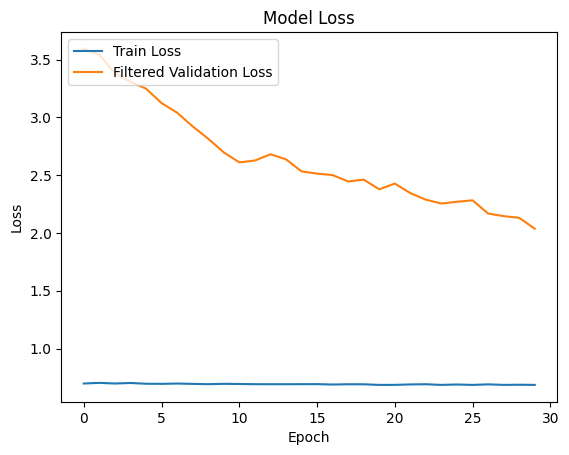

In [50]:
# Plotting training & validation loss values
plt.plot(loss_history, label='Train Loss')
plt.plot(val_loss_conf_history, label='Filtered Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

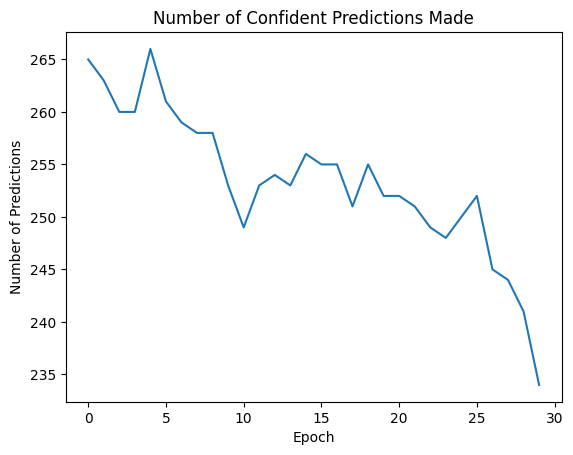

In [51]:
# Plot number of predictions made
plt.plot(num_predictions)
plt.title('Number of Confident Predictions Made')
plt.xlabel('Epoch')
plt.ylabel('Number of Predictions')
plt.show()

In [47]:
# Make predictions
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)
# Evaluate predictions
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
              precision    recall  f1-score   support

       False       0.53      0.22      0.31        72
        True       0.50      0.80      0.62        70

    accuracy                           0.51       142
   macro avg       0.52      0.51      0.46       142
weighted avg       0.52      0.51      0.46       142

